# **Boston House Price Prediction**

In [ ]:
#loading the libraries
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

#Sagemaker specific libraries
import sagemaker 
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

**Object representing the SageMaker session that we are currently operating in**

In [ ]:

session = sagemaker.Session()

In [ ]:
# retrieving the data from sklearn
boston = load_boston()

**Preparing the data**

In [ ]:
#Loading the training and target data
X_bos = pd.DataFrame(boston.data, columns = boston.feature_names)
Y_bos = pd.DataFrame(boston.target)

# **Splitting the Train, validation and test data**

In [ ]:
#Train/Test split
X_train, X_test, Y_train, Y_test = train_test_split(X_bos, Y_bos, test_size=0.30)

#Train/Validation split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.30)

In [ ]:
data_dir = './boston_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

# **Uploading the data files to S3 bucket**

In [ ]:
prefix = 'boston-ML'
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

**Utility method to construct the image name for the training container**

In [ ]:
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-2')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


**Object representing the IAM role that we are currently assigned**

In [ ]:
role = get_execution_role()

# **Constructing the Estimator object**

In [ ]:
#xgboost estimator
xgb = sagemaker.estimator.Estimator(container, role, instance_count=1, instance_type='ml.m4.xlarge', output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix), sagemaker_session=session)

**Setting the Hyperparameters**

In [ ]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

# **Training**

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=val_location, content_type='csv')
xgb.fit({'train': s3_input_train, 'validation':s3_input_validation})

2021-05-19 21:47:21 Starting - Starting the training job...
2021-05-19 21:47:23 Starting - Launching requested ML instancesProfilerReport-1621460841: InProgress
......
2021-05-19 21:48:32 Starting - Preparing the instances for training......
2021-05-19 21:49:43 Downloading - Downloading input data...
2021-05-19 21:50:21 Training - Downloading the training image...
2021-05-19 21:50:50 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:50:47] 247x13 matrix with 3211 entries loaded fr

# **Model evaluation**

In [ ]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

..............................
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] nginx config: 
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|

In [ ]:
xgb_transformer.wait()

[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] nginx config: 
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-05-19:21:56:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameter

In [ ]:
#Moving data back from s3 bucket
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-central-1-547975329324/sagemaker-xgboost-2021-05-19-21-51-34-574/test.csv.out to boston_data/test.csv.out


In [ ]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
error = np.sqrt(mse(Y_pred,Y_test))
print(error)

3.6071982464825165


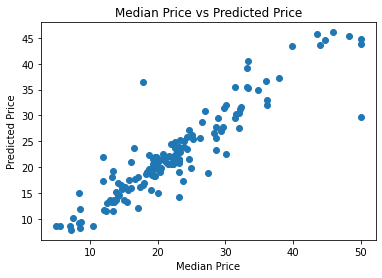

In [ ]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")
plt.show()

# **Calling deploy method to start an endpoint instance**

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------------------!